In [1]:
import os
import gc
import time
import pickle
import numpy as np; np.random.seed(42)
import pandas as pd
from datetime import datetime
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster
from tsforest.utils import make_time_range
from tsforest.metrics import compute_rmse

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, compute_weights, reduce_mem_usage
from evaluation import _WRMSSEEvaluator, WRMSSEEvaluator, Evaluator, WRMSSEEvaluatorL12

def trimean(array, axis=0):
    quantiles = np.percentile(array, [25, 50, 75], axis=axis)
    return (quantiles[0,:] + 2*quantiles[1,:] + quantiles[2,:])/4

SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71]

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
logger = open(f"../logs/pipeline-level12-model-by-store-{datetime.now()}", "w")

***
# Input data

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

scaling_input = pd.read_parquet("../input/scaling_input.parquet")
weighting_input = pd.read_parquet("../input/weighting_input.parquet")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46796220 entries, 0 to 46796219
Data columns (total 43 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ts_id              int16         
 1   item_id            int16         
 2   dept_id            int8          
 3   cat_id             int8          
 4   store_id           int8          
 5   state_id           int8          
 6   y                  int16         
 7   ds                 datetime64[ns]
 8   snap_CA            int8          
 9   snap_TX            int8          
 10  snap_WI            int8          
 11  snap_CA_cum        int8          
 12  snap_TX_cum        int8          
 13  snap_WI_cum        int8          
 14  event_name_1       int8          
 15  event_type_1       int8          
 16  event_name_2       int8          
 17  event_type_2       int8          
 18  sell_price         float32       
 19  n_prices           float32       
 20  regular_price      flo

***
# Models configuration

In [5]:
model_params = {
    'objective':'tweedie',
    'tweedie_variance_power': 1.1,
    'metric':'None',
    'num_iterations':100000,
    'early_stopping_rounds':200,
    'max_bin': 127,
    'bin_construct_sample_cnt':6000000,
    'num_leaves': 2**9-1,
    'min_data_in_leaf': 2**9-1,
    'learning_rate': 0.03, 
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.9,
    #'feature_fraction_bynode':0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':7,
    'boost_from_average': False,
    'first_metric_only': True,
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress", 
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

exclude_features = [
    "ts_id",
    "store_id",
    "state_id",
    "event_type_1",
    "event_name_2",
    "event_type_2",
    "prev_newyear",
    "post_newyear",
    "no_stock_days",
    "price_momentum_q",
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    #"lags": list(range(1,15)),
    "window_shifts":[1,7,28,56],
    "window_functions":["mean","median","std","kurt",],
    "window_sizes":[7,28],
    "exclude_features":exclude_features,
    "categorical_features":{"item_id":"GLMMEncoder", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "event_name_1":"default",
    },
    "ts_uid_columns":["item_id",]
}

lagged_features = list()
if "lags" in model_kwargs.keys():
    lag_features = [f"lag{lag}" for lag in model_kwargs["lags"]]
    lagged_features.extend(lag_features)
if "window_functions" in model_kwargs.keys():
    rw_features = [f"{window_func}{window_size}_shift{window_shift}" 
                   for window_func in model_kwargs["window_functions"]
                   for window_size in model_kwargs["window_sizes"]
                   for window_shift in model_kwargs["window_shifts"]]
    lagged_features.extend(rw_features)
    
lagged_features_to_dropna = [feat for feat in lagged_features if feat not in ["skew", "kurt"]]

In [6]:
logger.write("#"*100+"\n")
logger.write(" MODEL CONFIGURATION ".center(100, "#")+"\n")
logger.write("#"*100+"\n\n")
logger.write(f"- model_params: \n{model_params}\n\n")
logger.write(f"- time_features: \n{model_kwargs['time_features']}\n\n")
if "lags" in model_kwargs.keys():
    logger.write(f"- lags: \n{model_kwargs['lags']}\n\n")
if "window_functions" in model_kwargs.keys():
    logger.write(f"- window_functions: \n{model_kwargs['window_functions']}\n\n")
if "window_shifts" in model_kwargs.keys():
    logger.write(f"- window_shifts: \n{model_kwargs['window_shifts']}\n\n")
if "window_sizes" in model_kwargs.keys():
    logger.write(f"- window_sizes: \n{model_kwargs['window_sizes']}\n\n")
logger.write(f"- categorical_features: \n{model_kwargs['categorical_features']}\n\n")
logger.flush()

***

In [7]:
valid_periods = [
    (pd.to_datetime("2015-04-25"), pd.to_datetime("2015-05-22")),
    (pd.to_datetime("2015-05-23"), pd.to_datetime("2015-06-19")),
    (pd.to_datetime("2016-03-28"), pd.to_datetime("2016-04-24")),
    (pd.to_datetime("2016-04-25"), pd.to_datetime("2016-05-22")),
]

####################################################################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-05-22 00:00:00')) ######
####################################################################################################


../lib/utils.py:57: RuntimeWarning:

Mean of empty slice



----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 1 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5985
[LightGBM] [Info] Number of data points in the train set: 2026344, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.926263
[50]	valid_0's wrmsseL12: 0.809005
[75]	valid_0's wrmsseL12: 0.76989
[100]	valid_0's wrmsseL12: 0.758664
[125]	valid_0's wrmsseL12: 0.754781
[150]	valid_0's wrmsseL12: 0.752879
[175]	valid_0's wrmsseL12: 0.751767
[200]	valid

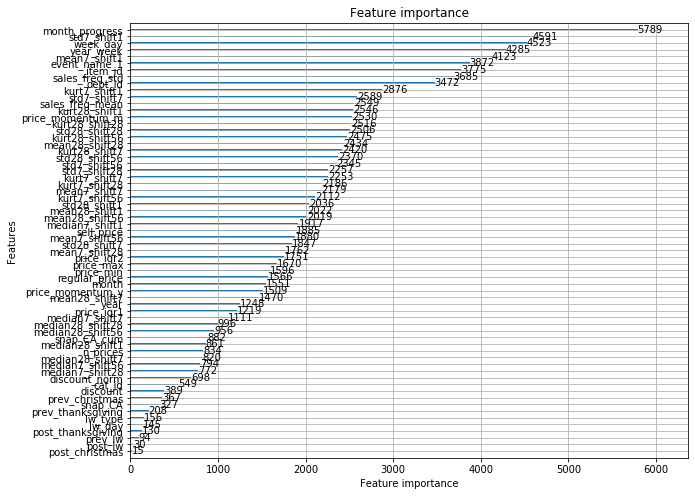

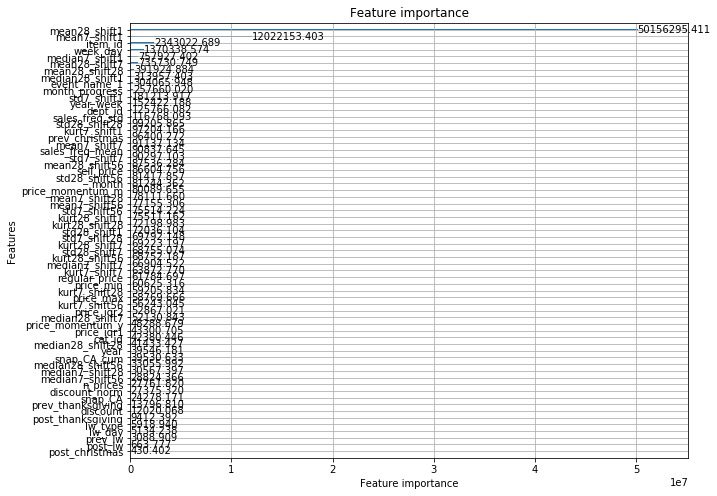

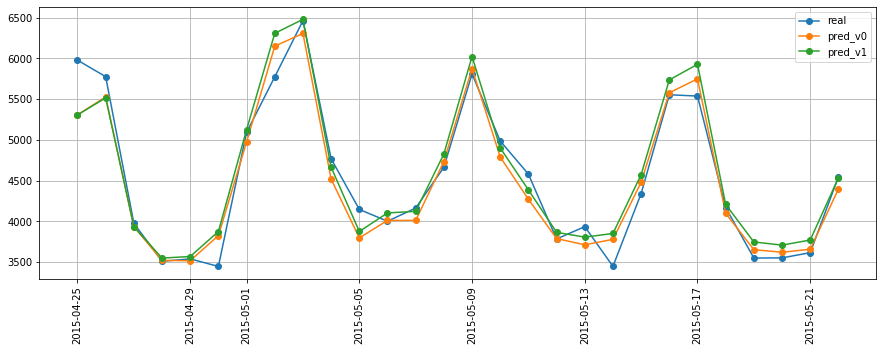

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 2 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5668
[LightGBM] [Info] Number of data points in the train set: 1708320, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.758363
[50]	valid_0's wrmsseL12: 0.705732
[75]	valid_0's wrmsseL12: 0.690119
[100]	valid_0's wrmsseL12: 0.685388
[125]	valid_0's wrmsseL12: 0.683359
[150]	valid_0's wrmsseL12: 0.68244
[175]	valid_0's wrmsseL12: 0.68213
[200]	valid_

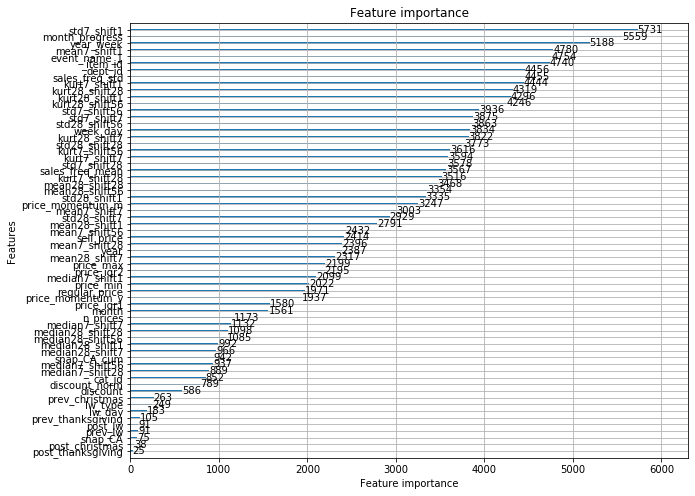

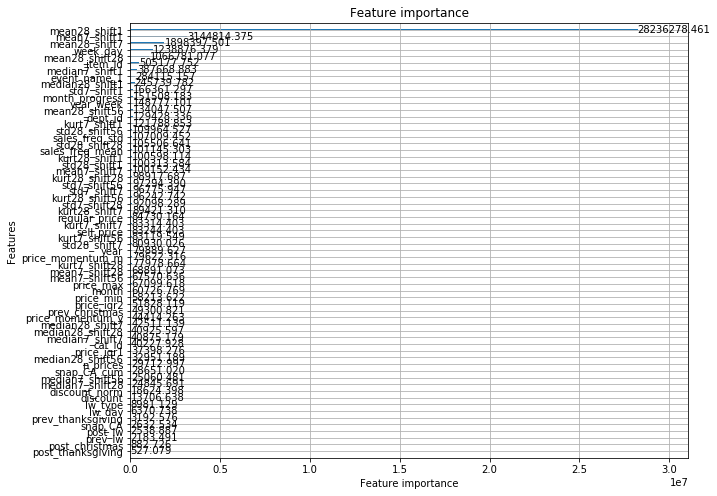

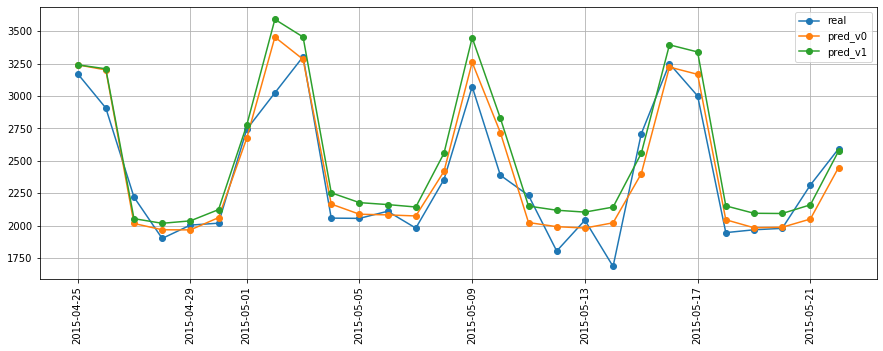

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 3 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129314 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5972
[LightGBM] [Info] Number of data points in the train set: 2157843, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.940291
[50]	valid_0's wrmsseL12: 0.793114
[75]	valid_0's wrmsseL12: 0.744788
[100]	valid_0's wrmsseL12: 0.731188
[125]	valid_0's wrmsseL12: 0.727678
[150]	valid_0's wrmsseL12: 0.72626
[175]	valid_0's wrmsseL12: 0.725452
[200]	valid

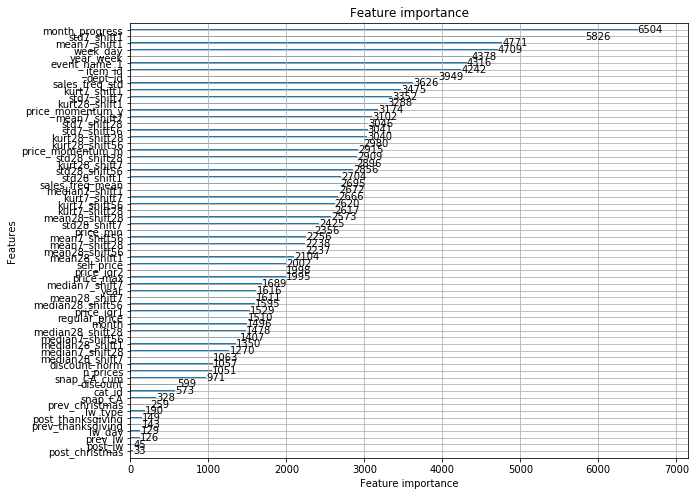

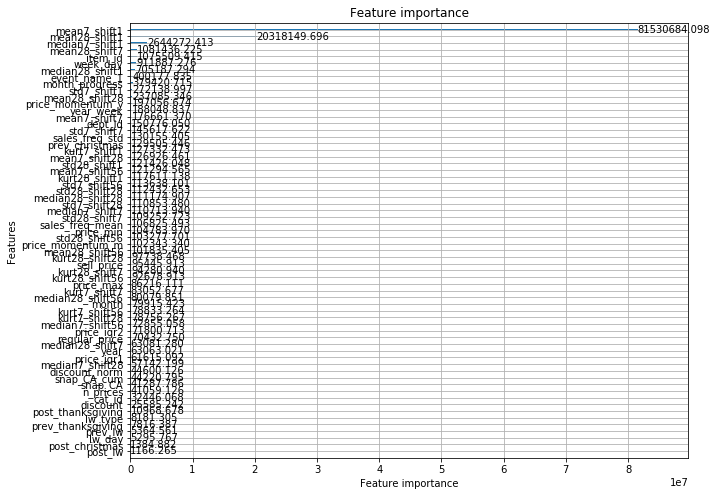

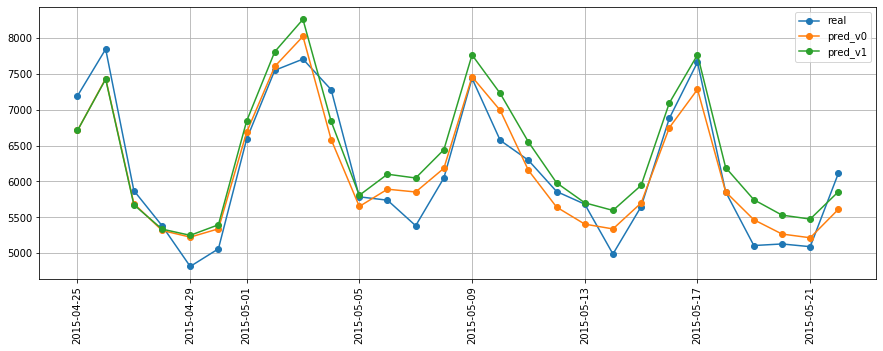

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 4 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5659
[LightGBM] [Info] Number of data points in the train set: 1709416, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.852024
[50]	valid_0's wrmsseL12: 0.790856
[75]	valid_0's wrmsseL12: 0.772773
[100]	valid_0's wrmsseL12: 0.767307
[125]	valid_0's wrmsseL12: 0.764822
[150]	valid_0's wrmsseL12: 0.764054
[175]	valid_0's wrmsseL12: 0.763456
[200]	vali

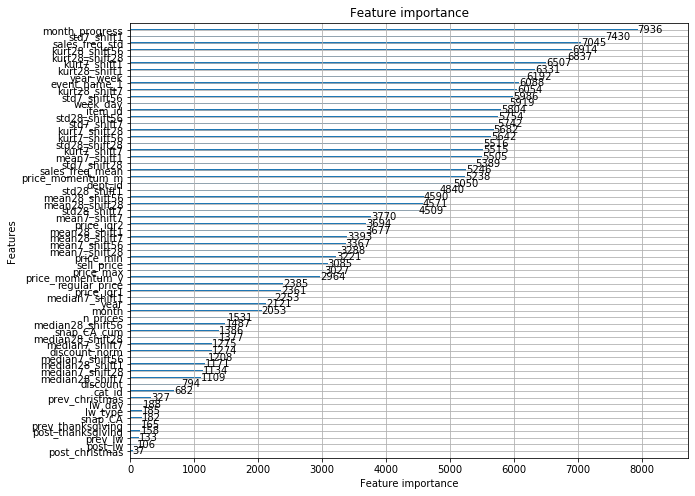

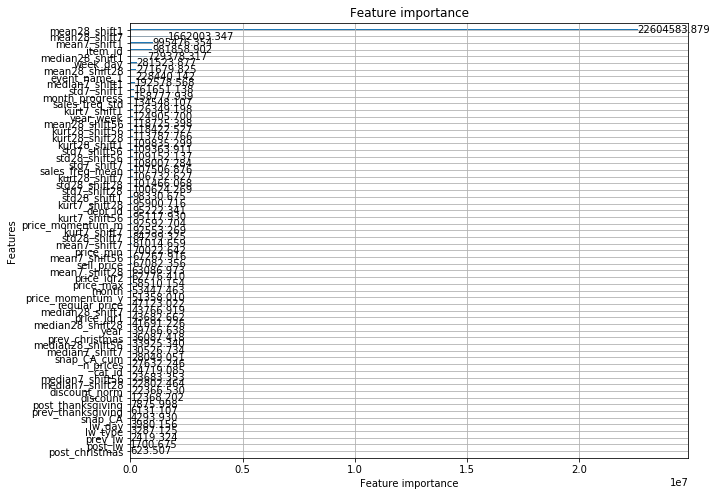

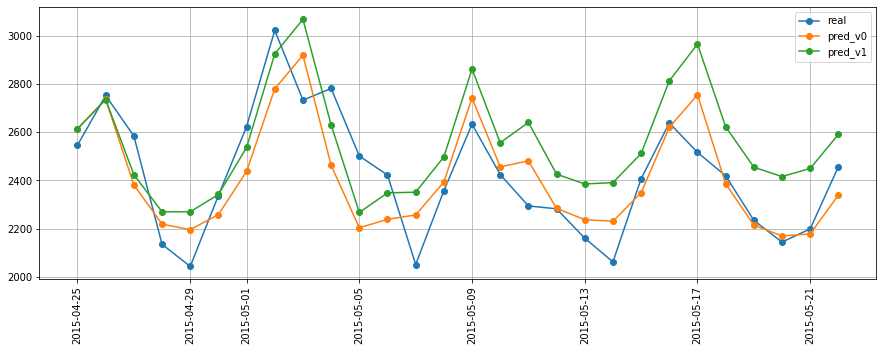

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 5 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5917
[LightGBM] [Info] Number of data points in the train set: 1712846, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.904688
[50]	valid_0's wrmsseL12: 0.804069
[75]	valid_0's wrmsseL12: 0.774543
[100]	valid_0's wrmsseL12: 0.766771
[125]	valid_0's wrmsseL12: 0.764673
[150]	valid_0's wrmsseL12: 0.763389
[175]	valid_0's wrmsseL12: 0.762889
[200]	vali

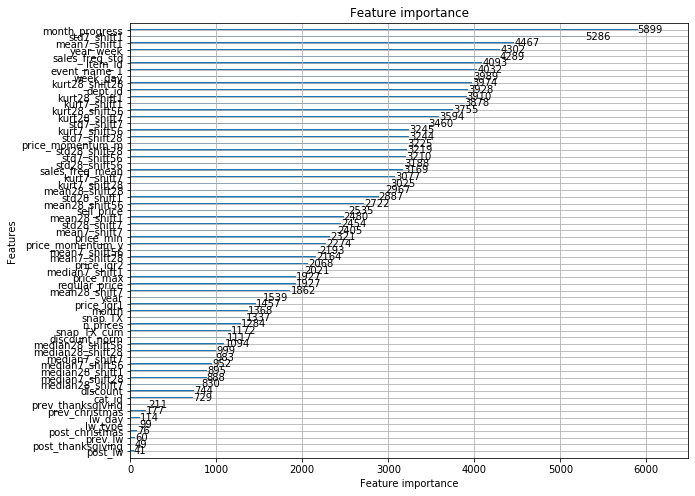

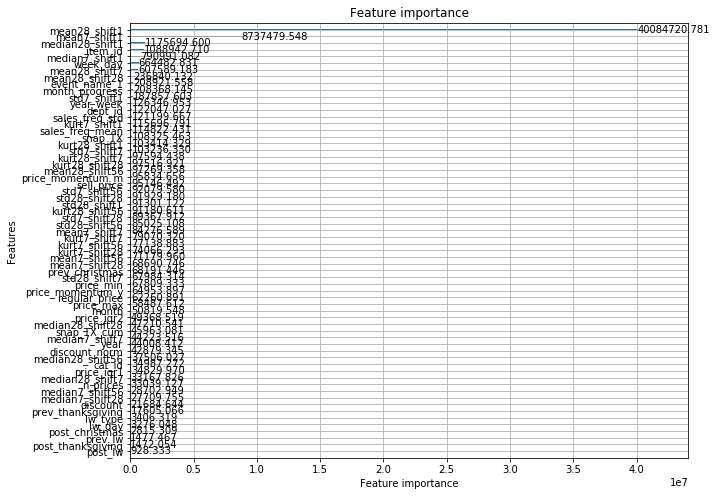

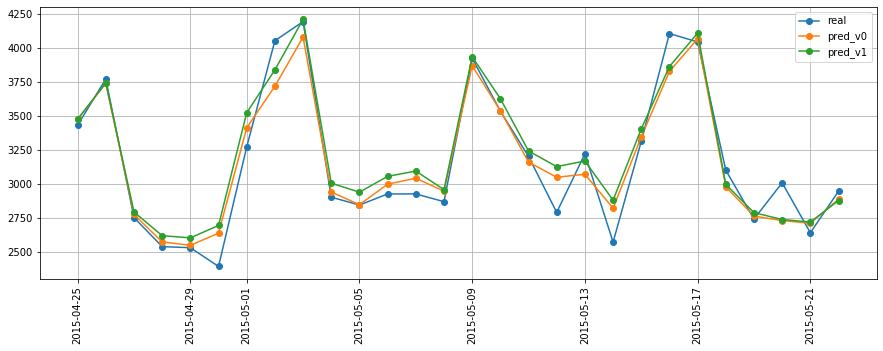

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 6 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5972
[LightGBM] [Info] Number of data points in the train set: 1935944, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.907163
[50]	valid_0's wrmsseL12: 0.779007
[75]	valid_0's wrmsseL12: 0.736142
[100]	valid_0's wrmsseL12: 0.72439
[125]	valid_0's wrmsseL12: 0.720861
[150]	valid_0's wrmsseL12: 0.71986
[175]	valid_0's wrmsseL12: 0.718675
[200]	valid_

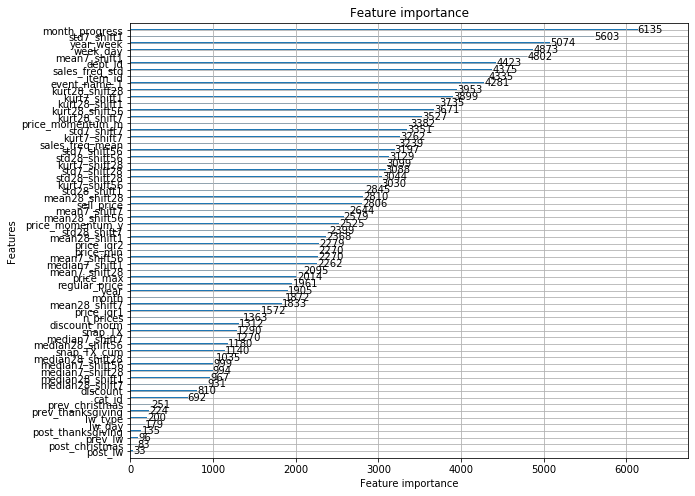

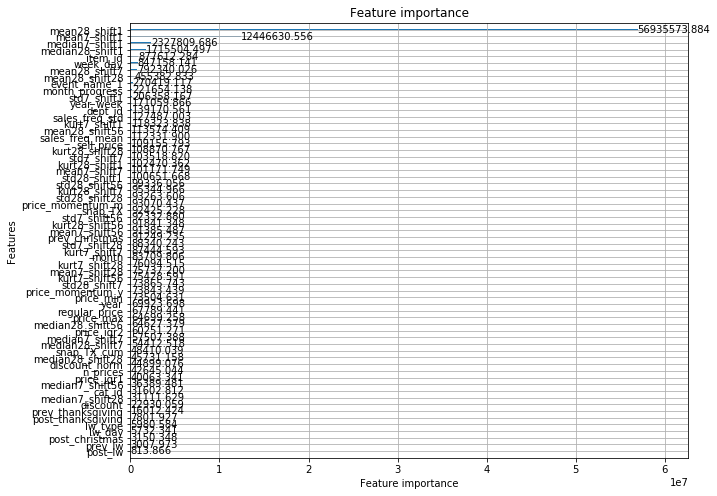

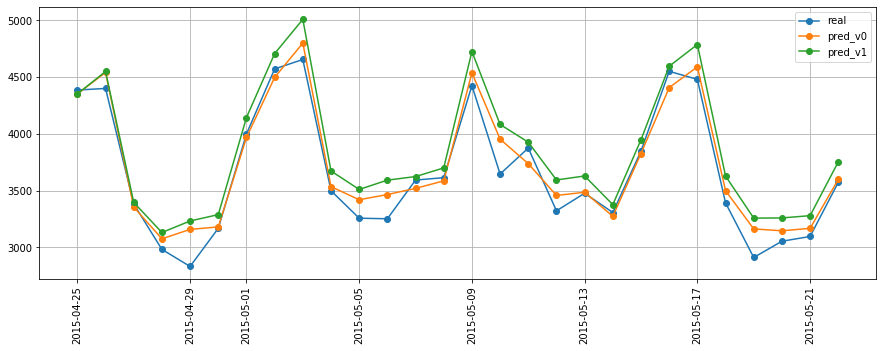

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 7 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5969
[LightGBM] [Info] Number of data points in the train set: 1716045, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 1.14581
[50]	valid_0's wrmsseL12: 0.967983
[75]	valid_0's wrmsseL12: 0.911803
[100]	valid_0's wrmsseL12: 0.894373
[125]	valid_0's wrmsseL12: 0.888409
[150]	valid_0's wrmsseL12: 0.886632
[175]	valid_0's wrmsseL12: 0.885199
[200]	valid

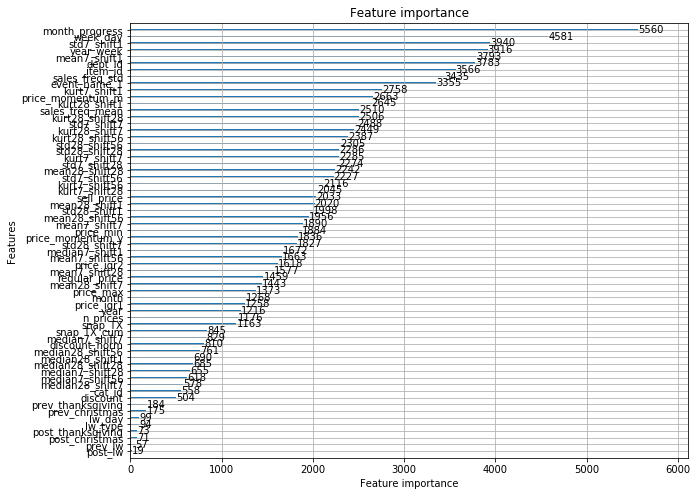

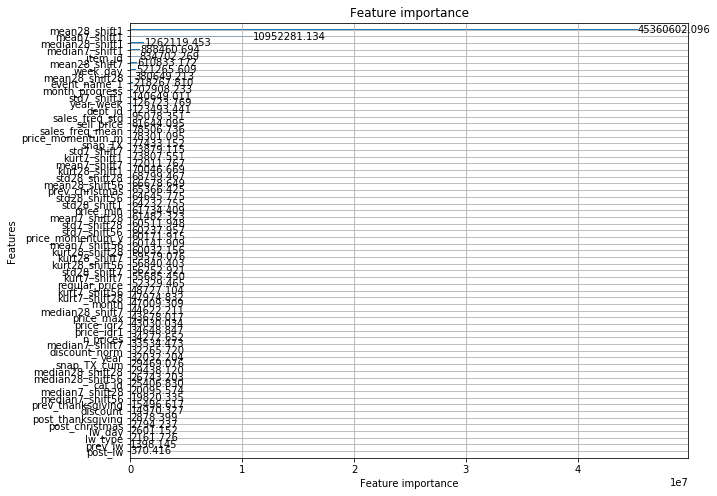

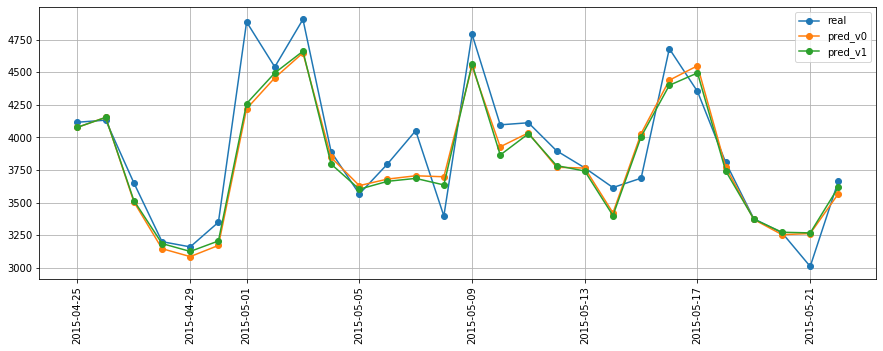

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 8 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5671
[LightGBM] [Info] Number of data points in the train set: 1764401, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.892349
[50]	valid_0's wrmsseL12: 0.813266
[75]	valid_0's wrmsseL12: 0.787742
[100]	valid_0's wrmsseL12: 0.779339
[125]	valid_0's wrmsseL12: 0.776332
[150]	valid_0's wrmsseL12: 0.775133
[175]	valid_0's wrmsseL12: 0.774659
[200]	vali

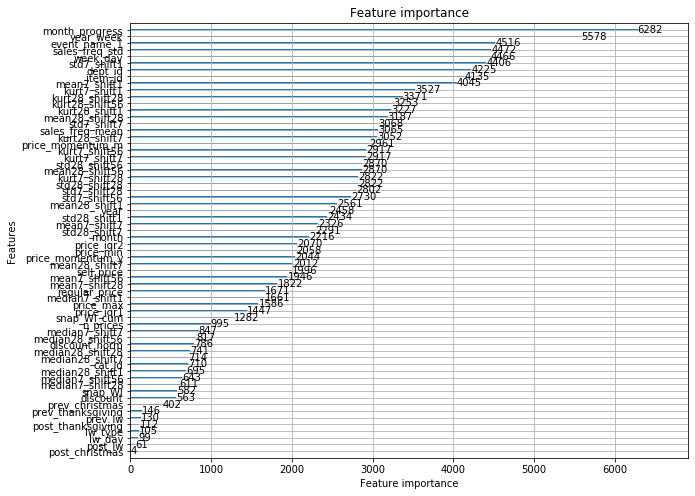

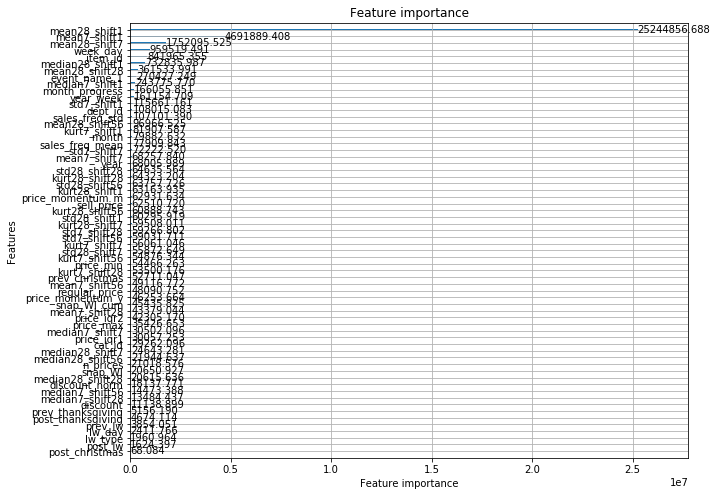

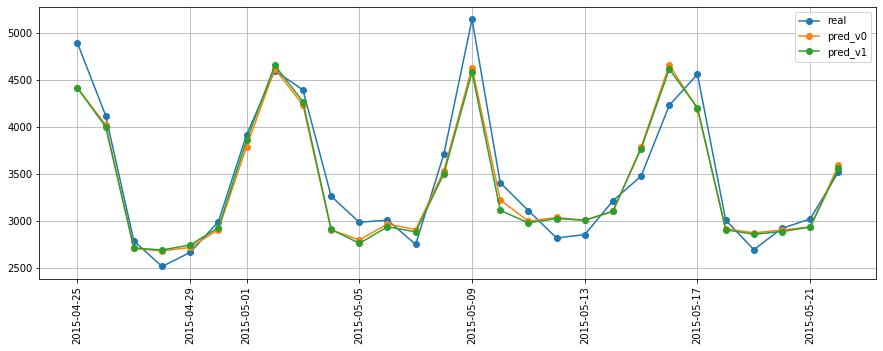

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 9 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5961
[LightGBM] [Info] Number of data points in the train set: 1579492, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.978769
[50]	valid_0's wrmsseL12: 0.840359
[75]	valid_0's wrmsseL12: 0.794565
[100]	valid_0's wrmsseL12: 0.77992
[125]	valid_0's wrmsseL12: 0.773793
[150]	valid_0's wrmsseL12: 0.770748
[175]	valid_0's wrmsseL12: 0.769226
[200]	valid

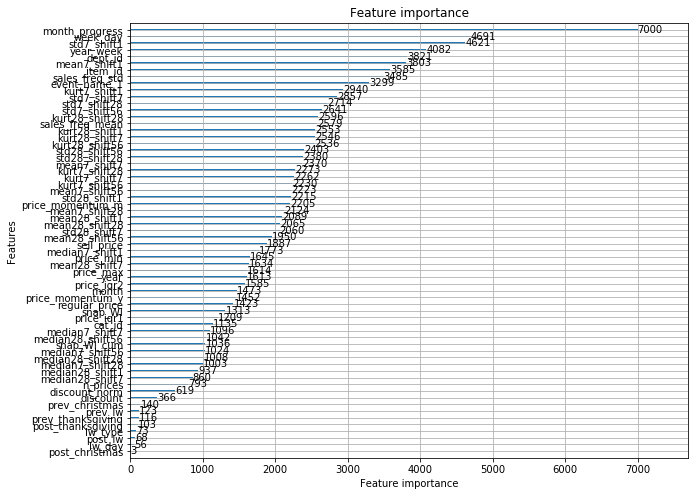

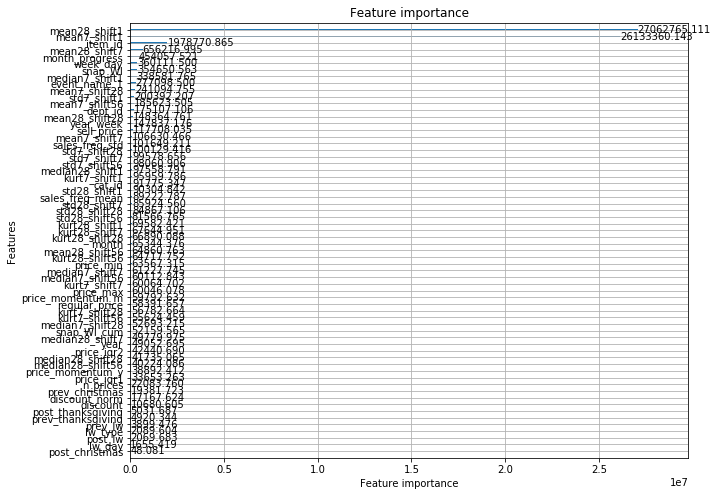

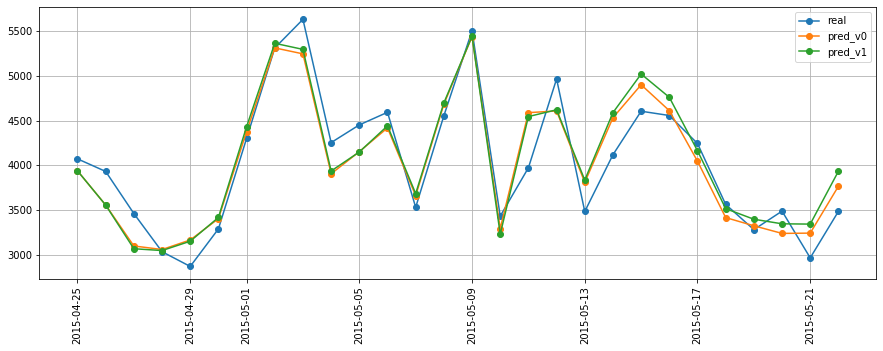

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 10 -------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5963
[LightGBM] [Info] Number of data points in the train set: 1699164, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.8536
[50]	valid_0's wrmsseL12: 0.746102
[75]	valid_0's wrmsseL12: 0.71031
[100]	valid_0's wrmsseL12: 0.698981
[125]	valid_0's wrmsseL12: 0.695213
[150]	valid_0's wrmsseL12: 0.693978
[175]	valid_0's wrmsseL12: 0.693174
[200]	valid_0

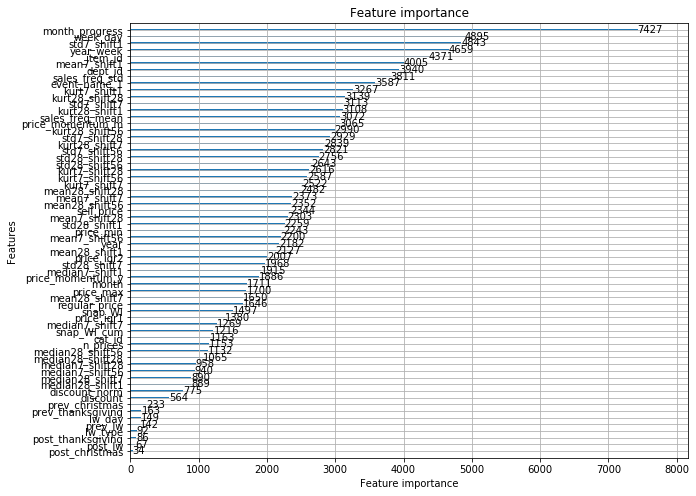

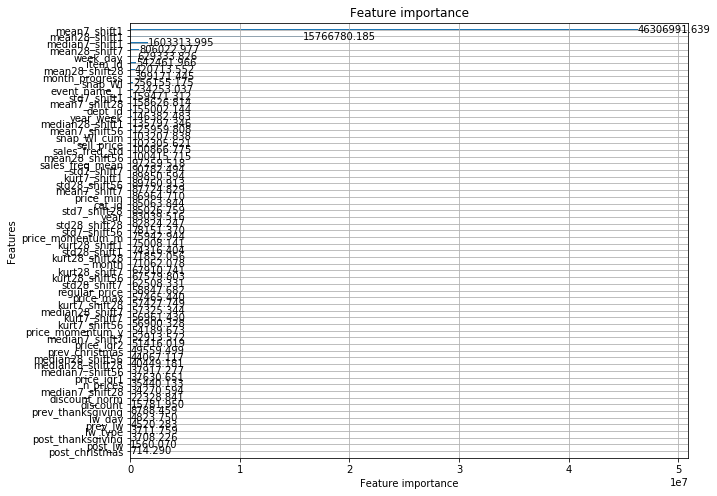

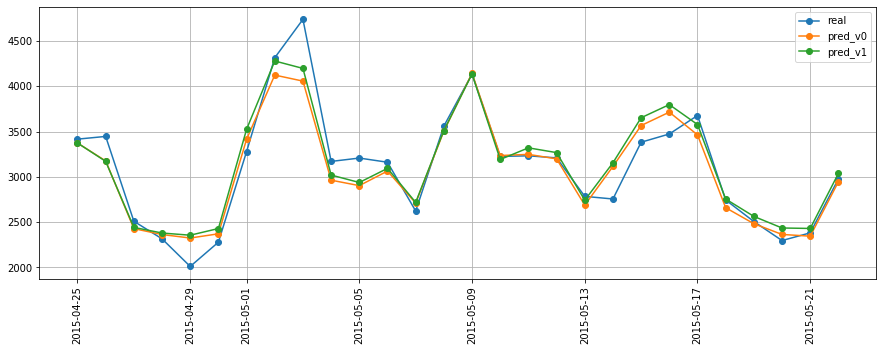


wrmsse: 0.4451525759329744
{'root': 0.2095146964654922, ('state_id',): 0.2670225457096825, ('store_id',): 0.3514268531805173, ('cat_id',): 0.29937401760377774, ('dept_id',): 0.35263103954443004, ('state_id', 'cat_id'): 0.351674573010312, ('state_id', 'dept_id'): 0.4044205440613631, ('store_id', 'cat_id'): 0.4358930215317356, ('store_id', 'dept_id'): 0.49521055988710055, ('item_id',): 0.7586611239792245, ('item_id', 'state_id'): 0.7229447519620212, ('item_id', 'store_id'): 0.6930571842600366}
####################################################################################################
##### Validation period: (Timestamp('2015-05-23 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 1 ------------------------------------------

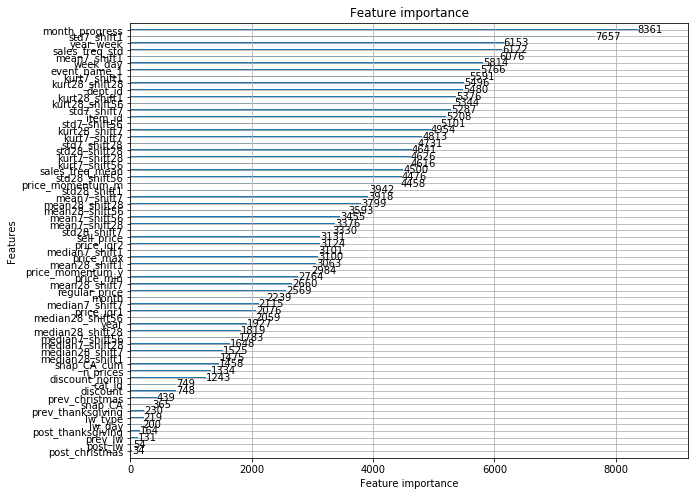

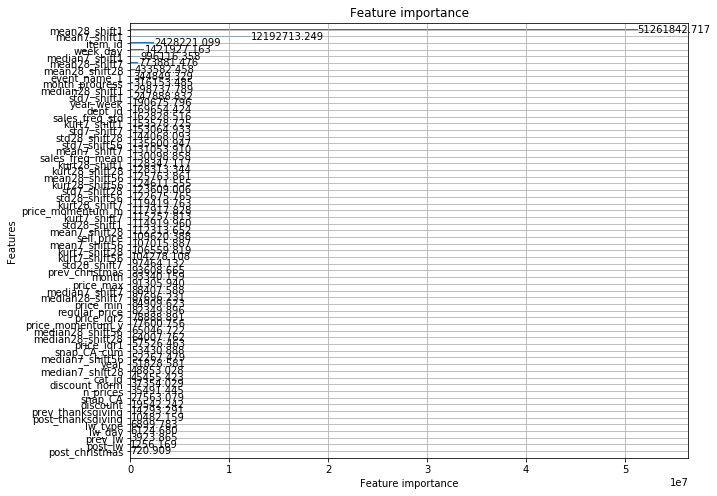

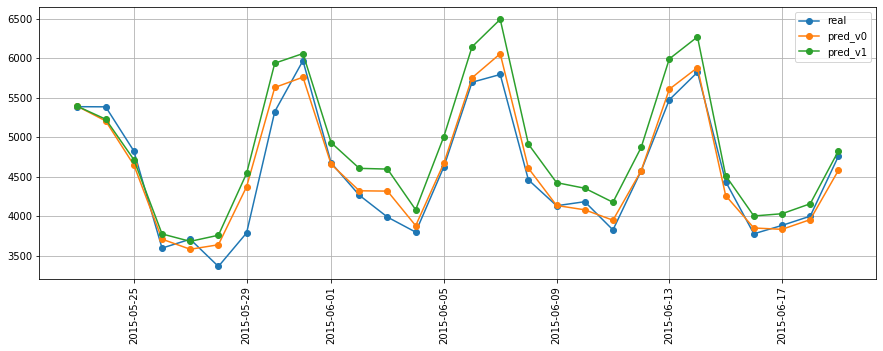

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 2 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.107443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5669
[LightGBM] [Info] Number of data points in the train set: 1750778, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.86311
[50]	valid_0's wrmsseL12: 0.801927
[75]	valid_0's wrmsseL12: 0.782672
[100]	valid_0's wrmsseL12: 0.776202
[125]	valid_0's wrmsseL12: 0.773802
[150]	valid_0's wrmsseL12: 0.772652
[175]	valid_0's wrmsseL12: 0.772025
[200]	valid

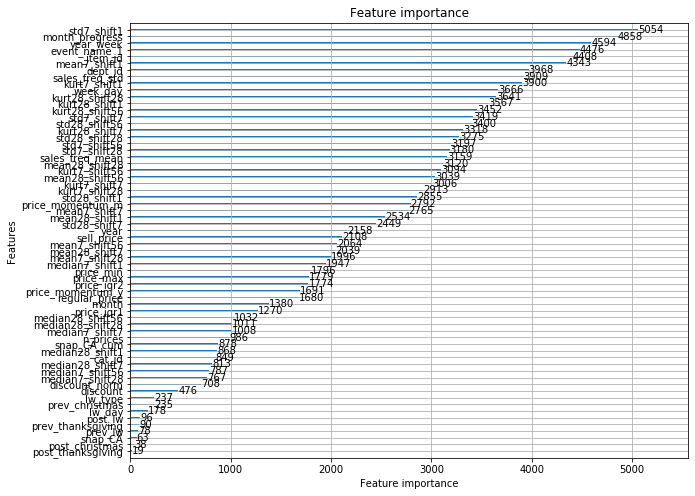

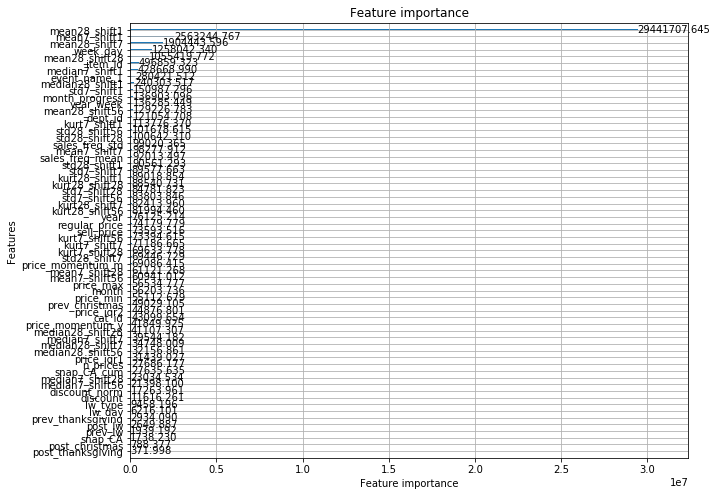

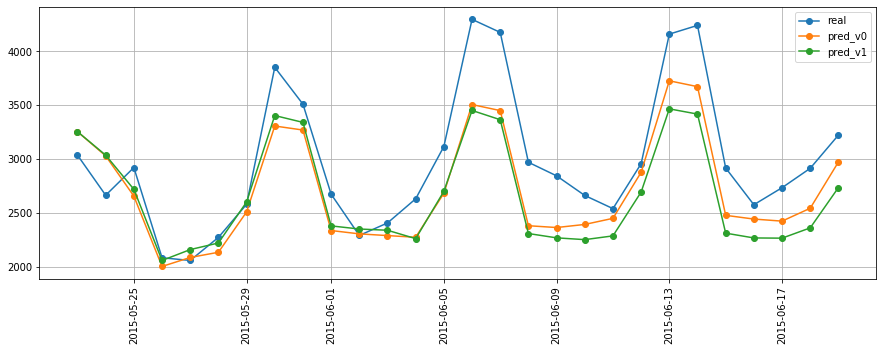

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 3 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5972
[LightGBM] [Info] Number of data points in the train set: 2215618, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.963837
[50]	valid_0's wrmsseL12: 0.819905
[75]	valid_0's wrmsseL12: 0.773803
[100]	valid_0's wrmsseL12: 0.760489
[125]	valid_0's wrmsseL12: 0.756391
[150]	valid_0's wrmsseL12: 0.754017
[175]	valid_0's wrmsseL12: 0.752902
[200]	vali

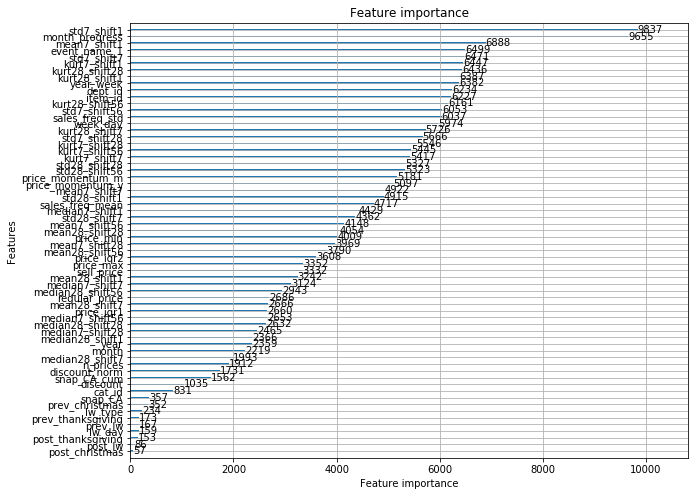

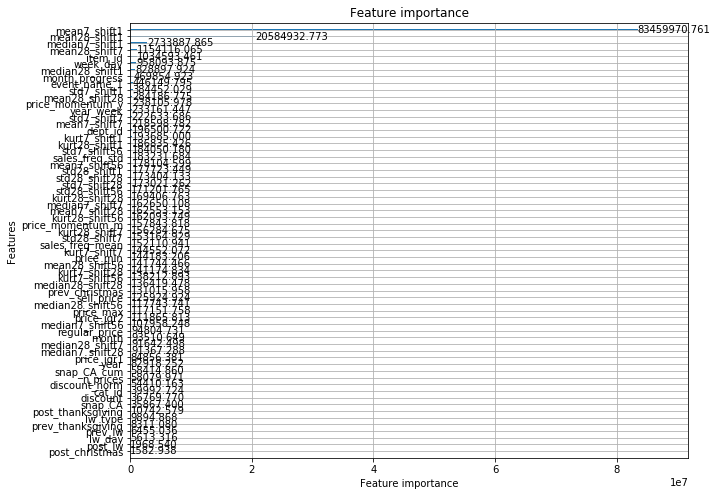

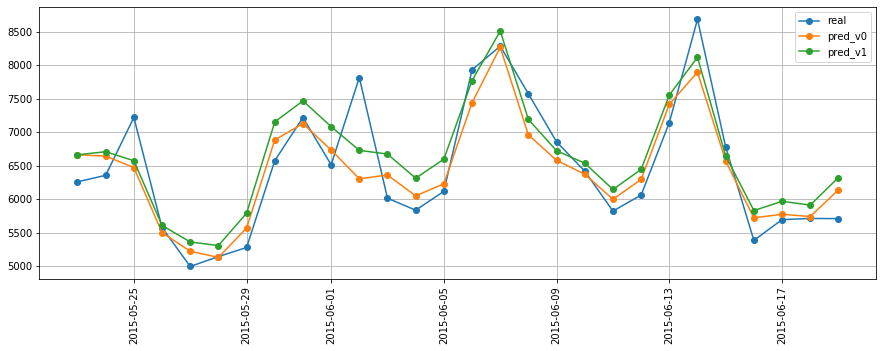

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 4 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.099668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5661
[LightGBM] [Info] Number of data points in the train set: 1753724, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.842359
[50]	valid_0's wrmsseL12: 0.783294
[75]	valid_0's wrmsseL12: 0.765889
[100]	valid_0's wrmsseL12: 0.760366
[125]	valid_0's wrmsseL12: 0.757947
[150]	valid_0's wrmsseL12: 0.756982
[175]	valid_0's wrmsseL12: 0.756373
[200]	vali

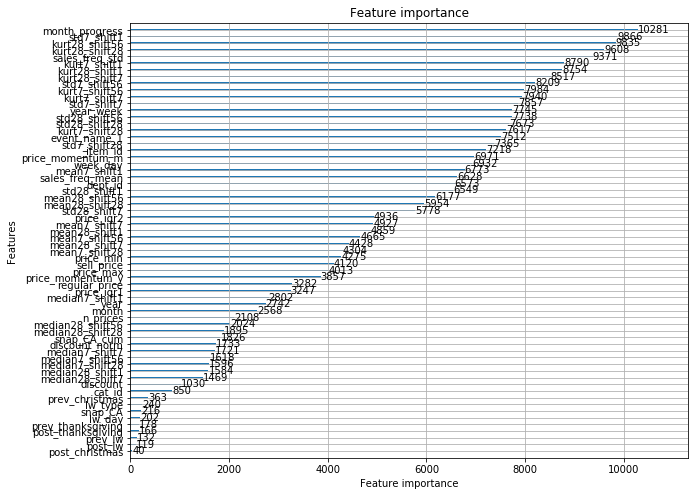

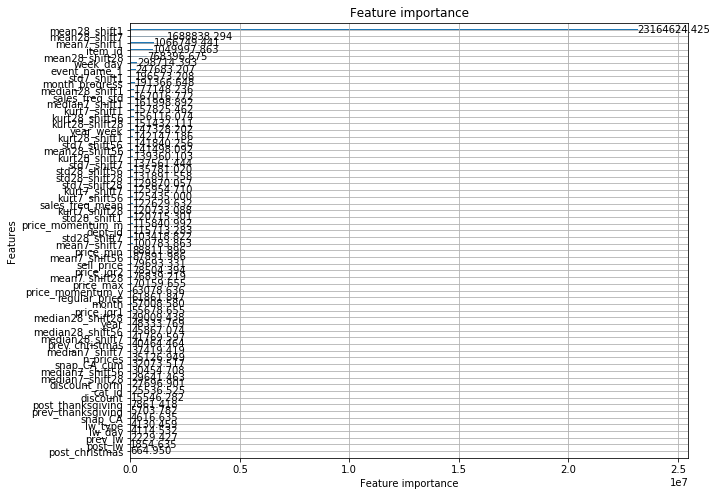

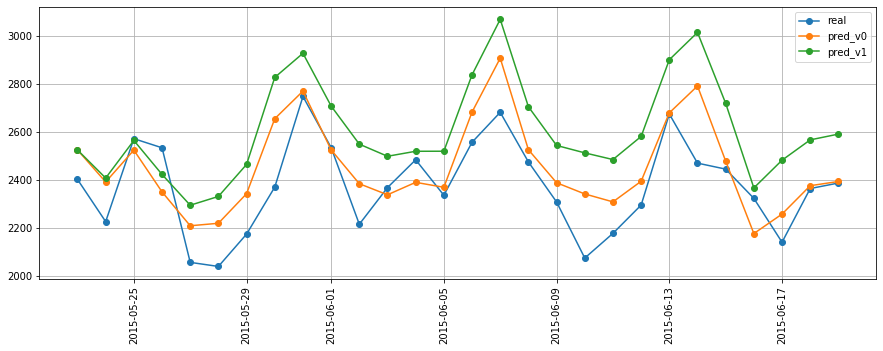

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 5 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5916
[LightGBM] [Info] Number of data points in the train set: 1755797, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.94344
[50]	valid_0's wrmsseL12: 0.851985
[75]	valid_0's wrmsseL12: 0.824405
[100]	valid_0's wrmsseL12: 0.81625
[125]	valid_0's wrmsseL12: 0.813884
[150]	valid_0's wrmsseL12: 0.813169
[175]	valid_0's wrmsseL12: 0.812707
[200]	valid_

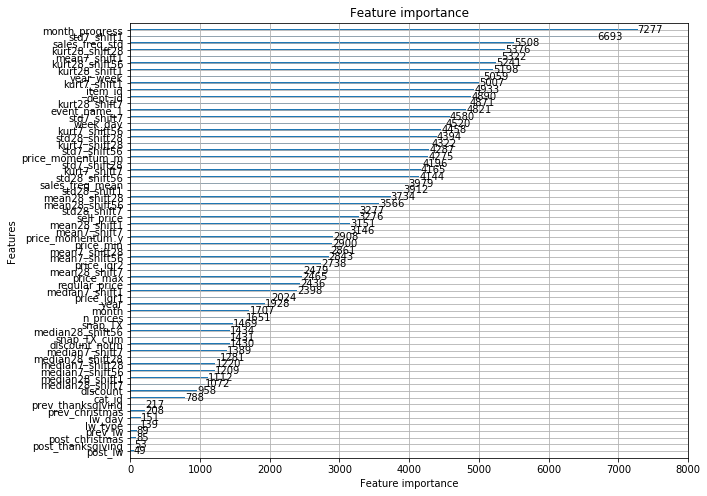

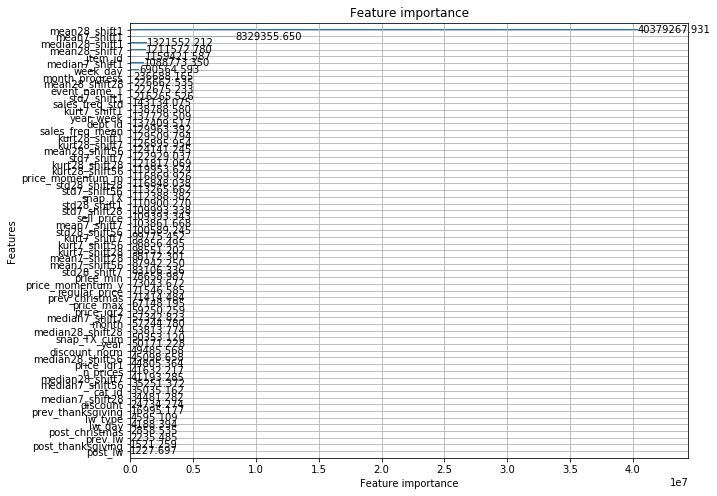

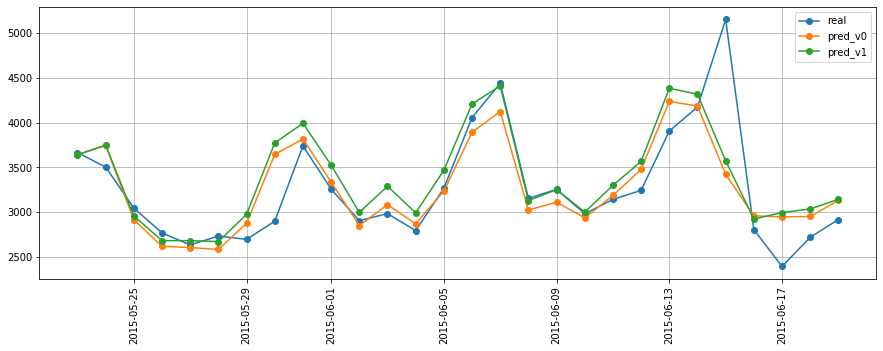

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 6 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5973
[LightGBM] [Info] Number of data points in the train set: 1984893, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.939387
[50]	valid_0's wrmsseL12: 0.825663
[75]	valid_0's wrmsseL12: 0.789027
[100]	valid_0's wrmsseL12: 0.777653
[125]	valid_0's wrmsseL12: 0.773722
[150]	valid_0's wrmsseL12: 0.771684
[175]	valid_0's wrmsseL12: 0.770871
[200]	vali

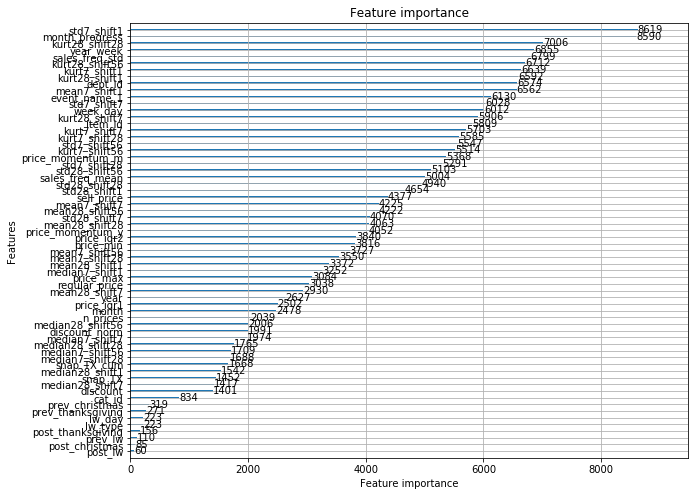

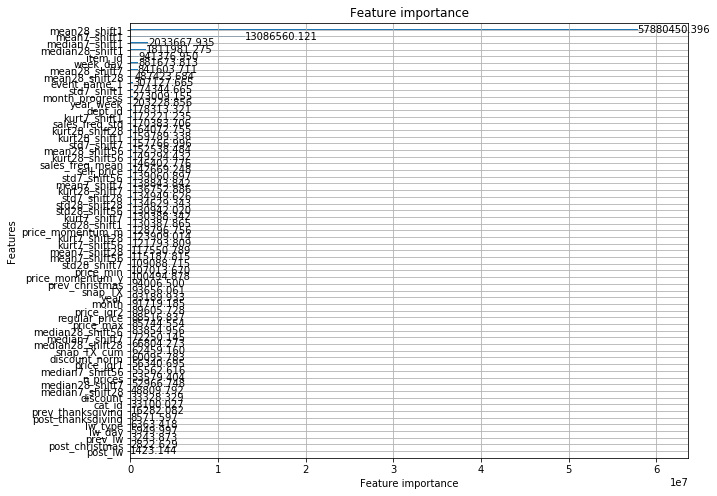

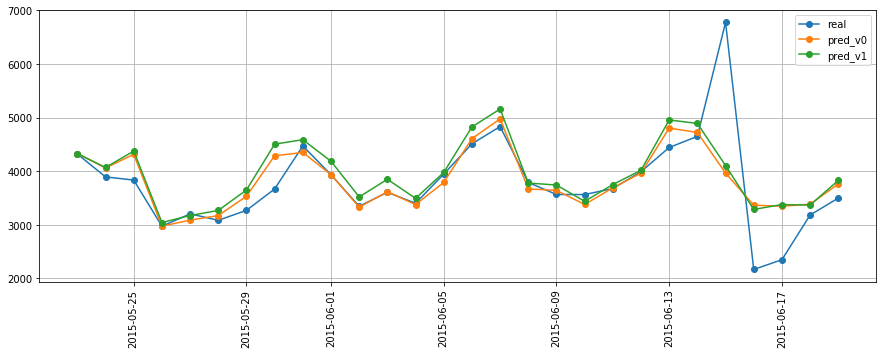

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 7 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.120964 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5971
[LightGBM] [Info] Number of data points in the train set: 1760666, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 1.12267
[50]	valid_0's wrmsseL12: 0.97554
[75]	valid_0's wrmsseL12: 0.931195
[100]	valid_0's wrmsseL12: 0.919623
[125]	valid_0's wrmsseL12: 0.915607
[150]	valid_0's wrmsseL12: 0.913201
[175]	valid_0's wrmsseL12: 0.912019
[200]	valid_

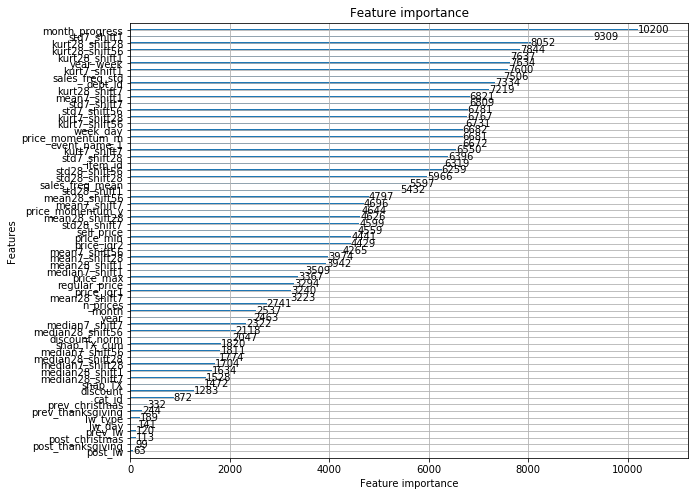

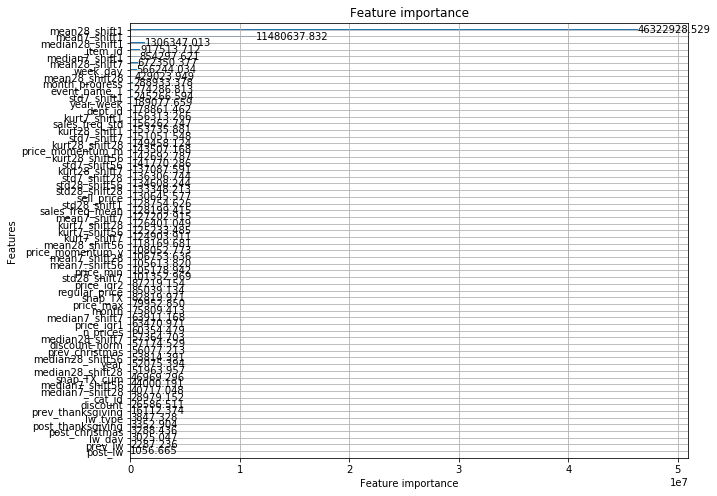

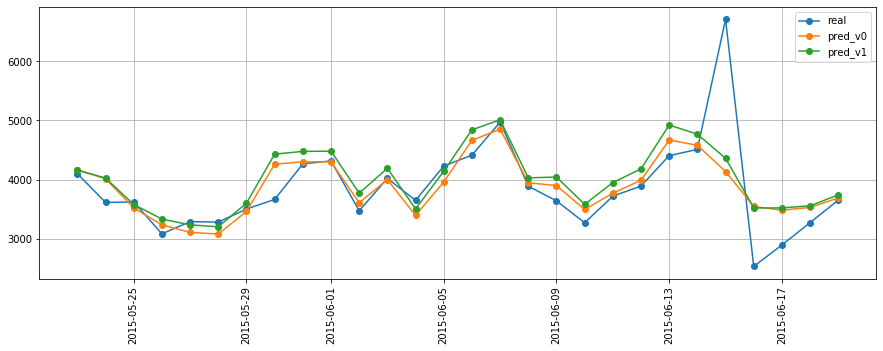

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 8 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.111836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5671
[LightGBM] [Info] Number of data points in the train set: 1815884, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.896912
[50]	valid_0's wrmsseL12: 0.815649
[75]	valid_0's wrmsseL12: 0.79048
[100]	valid_0's wrmsseL12: 0.782969
[125]	valid_0's wrmsseL12: 0.780505
[150]	valid_0's wrmsseL12: 0.779357
[175]	valid_0's wrmsseL12: 0.778974
[200]	valid

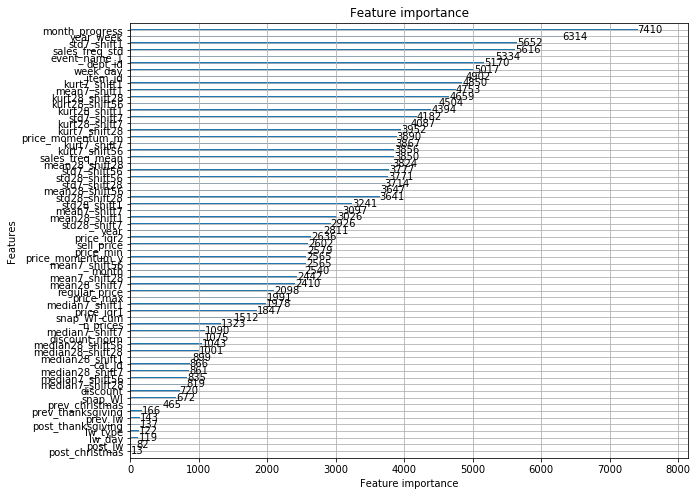

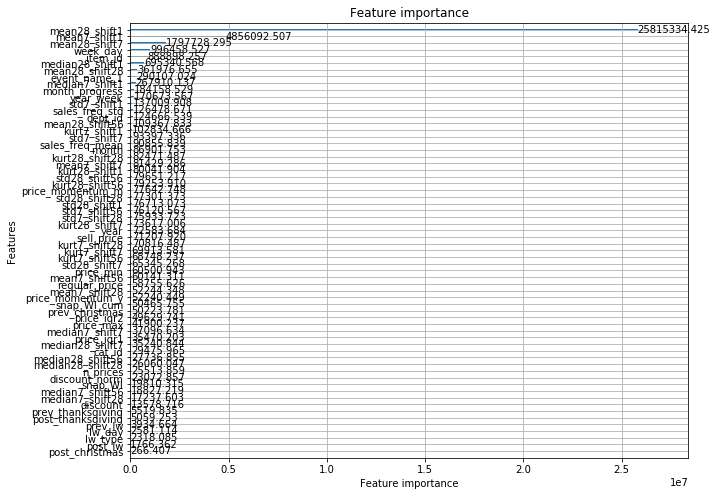

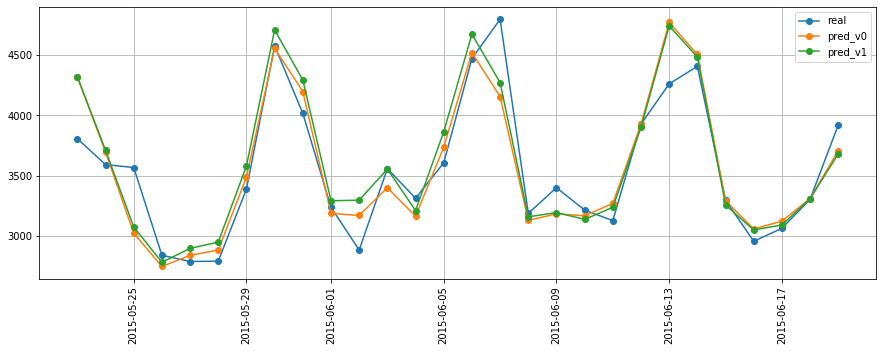

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 9 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5960
[LightGBM] [Info] Number of data points in the train set: 1622116, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.948936
[50]	valid_0's wrmsseL12: 0.829752
[75]	valid_0's wrmsseL12: 0.792927
[100]	valid_0's wrmsseL12: 0.783184
[125]	valid_0's wrmsseL12: 0.780228
[150]	valid_0's wrmsseL12: 0.778872
[175]	valid_0's wrmsseL12: 0.778674
[200]	vali

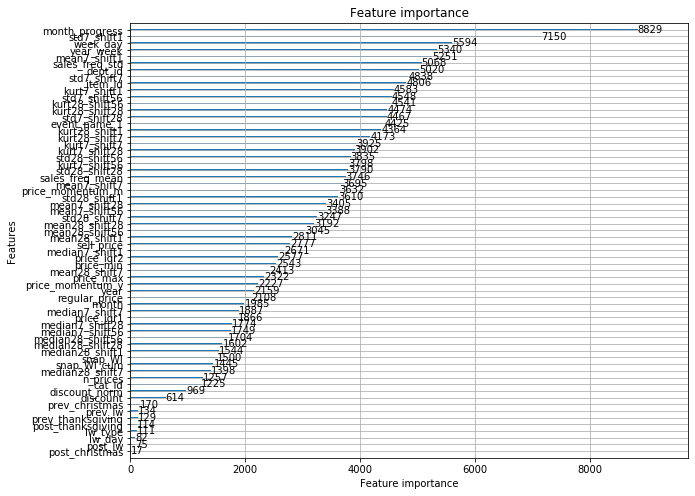

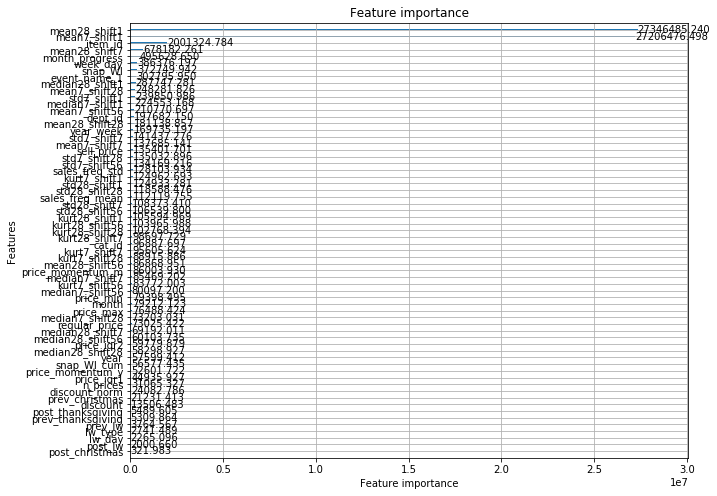

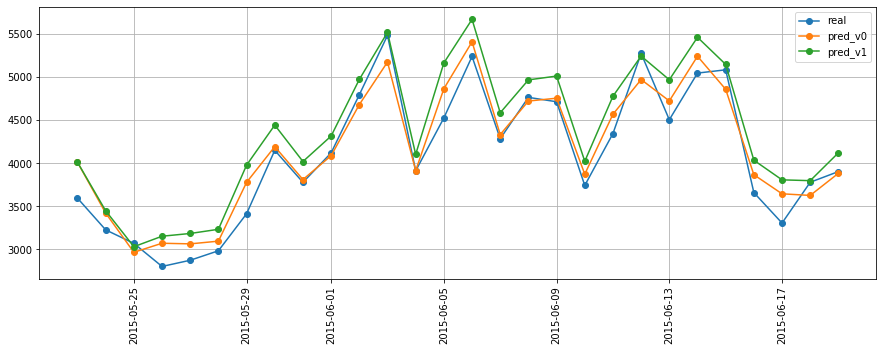

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 10 -------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.116656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5963
[LightGBM] [Info] Number of data points in the train set: 1739778, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.843682
[50]	valid_0's wrmsseL12: 0.747261
[75]	valid_0's wrmsseL12: 0.715987
[100]	valid_0's wrmsseL12: 0.707159
[125]	valid_0's wrmsseL12: 0.704046
[150]	valid_0's wrmsseL12: 0.70209
[175]	valid_0's wrmsseL12: 0.701106
[200]	valid

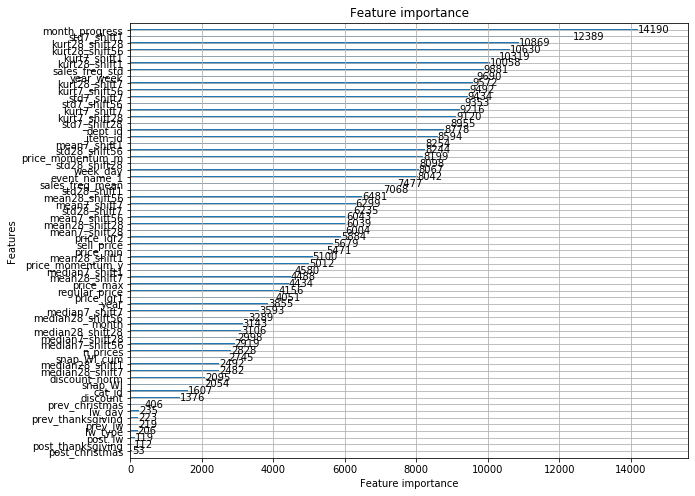

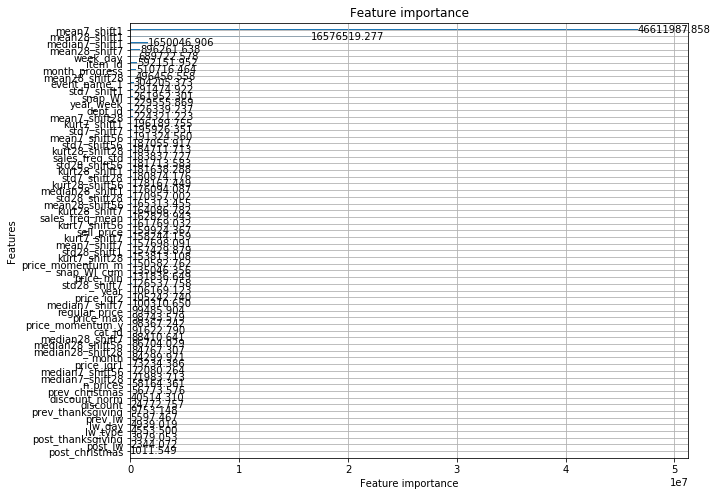

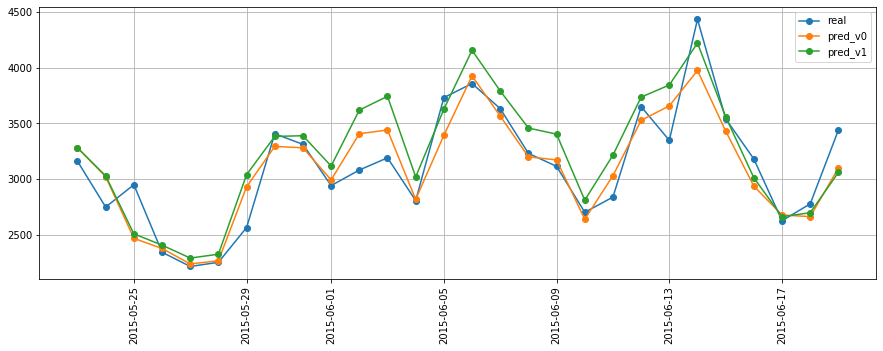


wrmsse: 0.6004847267156609
{'root': 0.3921196144183397, ('state_id',): 0.43984084407061597, ('store_id',): 0.5849110196261781, ('cat_id',): 0.48680506188404093, ('dept_id',): 0.533094236897484, ('state_id', 'cat_id'): 0.5231142310962201, ('state_id', 'dept_id'): 0.5899264397821586, ('store_id', 'cat_id'): 0.6397050513434294, ('store_id', 'dept_id'): 0.6796982254000146, ('item_id',): 0.8270430448033598, ('item_id', 'state_id'): 0.7765281515852694, ('item_id', 'store_id'): 0.733030799680821}
####################################################################################################
##### Validation period: (Timestamp('2016-03-28 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################
----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 1 --------------------------------------------

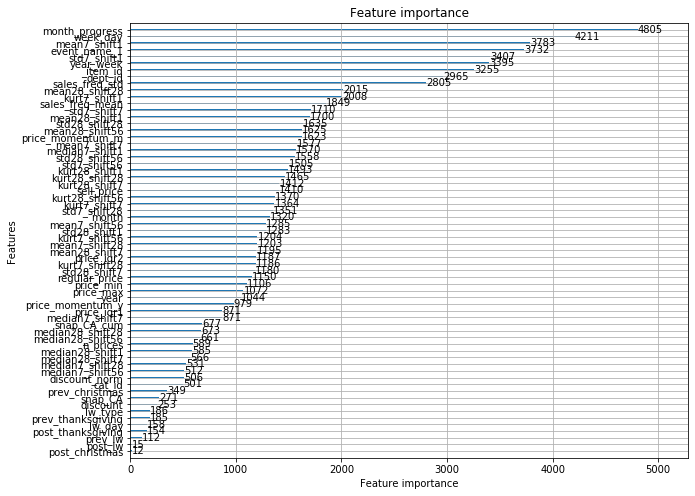

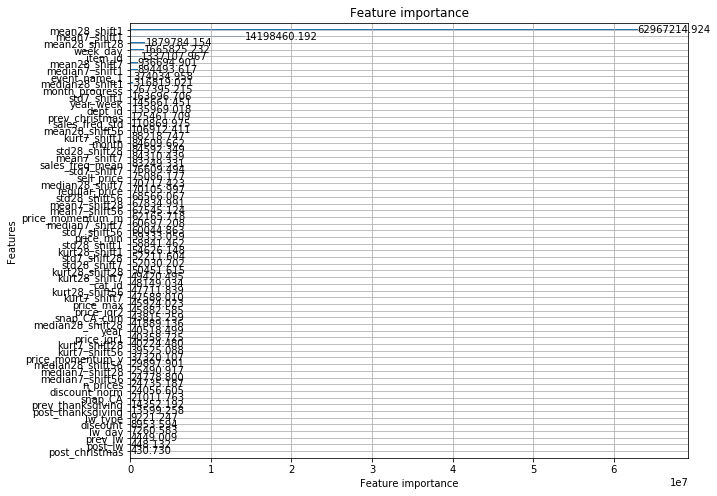

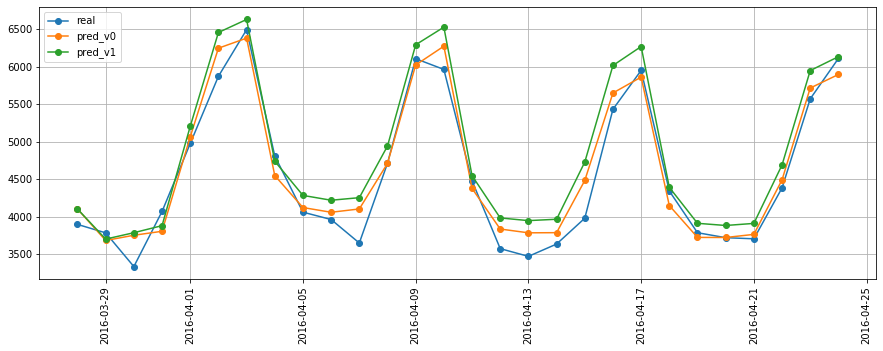

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 2 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.140726 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5721
[LightGBM] [Info] Number of data points in the train set: 2321765, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.964117
[50]	valid_0's wrmsseL12: 0.870739
[75]	valid_0's wrmsseL12: 0.840282
[100]	valid_0's wrmsseL12: 0.830645
[125]	valid_0's wrmsseL12: 0.827308
[150]	valid_0's wrmsseL12: 0.826795
[175]	valid_0's wrmsseL12: 0.827074
[200]	vali

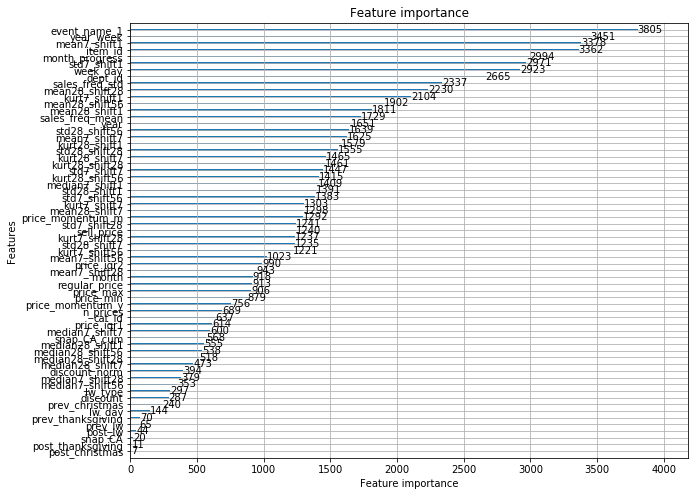

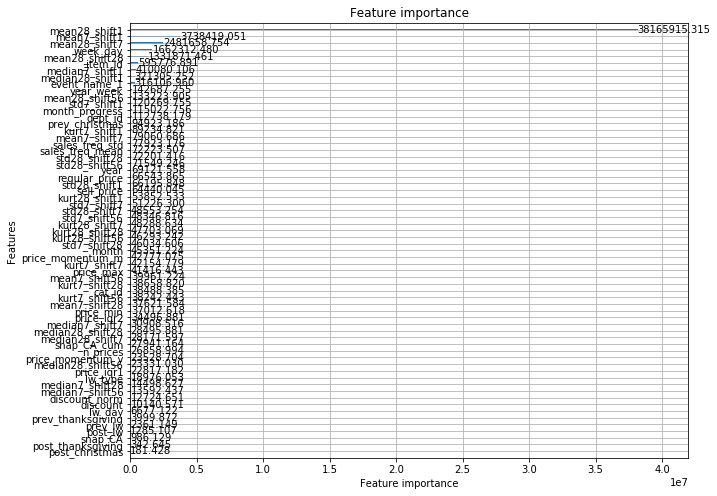

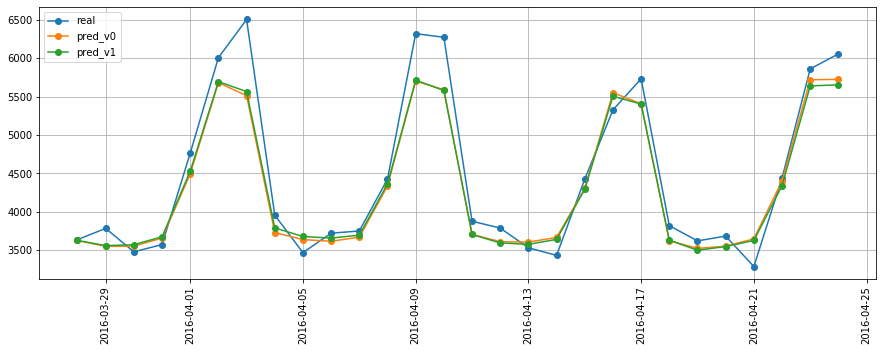

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 3 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.182947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5979
[LightGBM] [Info] Number of data points in the train set: 2856354, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.966385
[50]	valid_0's wrmsseL12: 0.825911
[75]	valid_0's wrmsseL12: 0.782833
[100]	valid_0's wrmsseL12: 0.771446
[125]	valid_0's wrmsseL12: 0.768583
[150]	valid_0's wrmsseL12: 0.767636
[175]	valid_0's wrmsseL12: 0.766694
[200]	vali

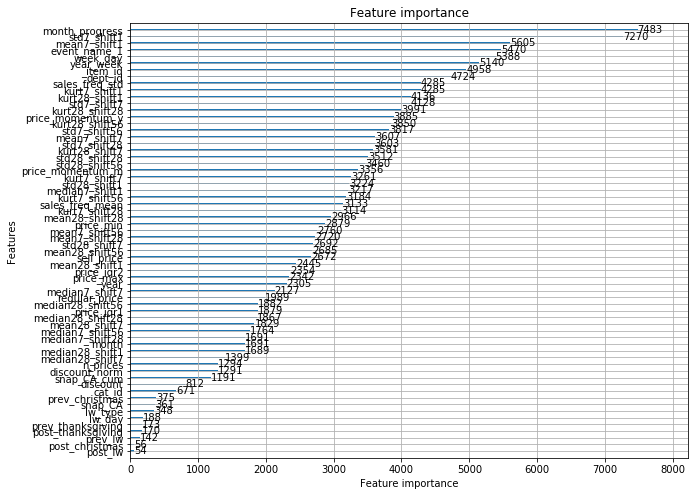

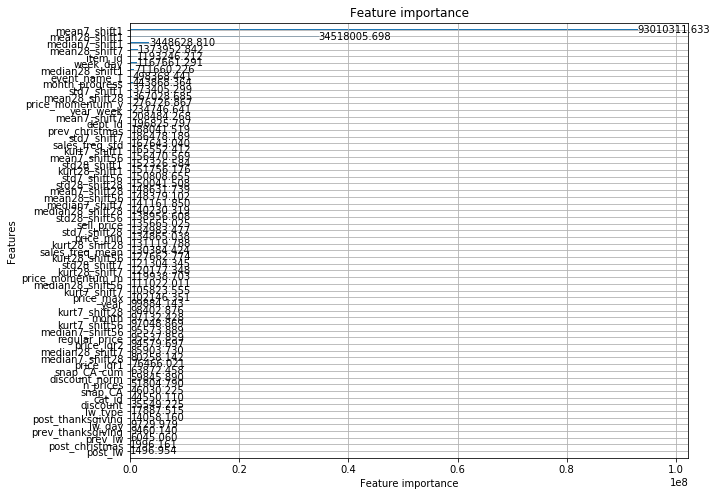

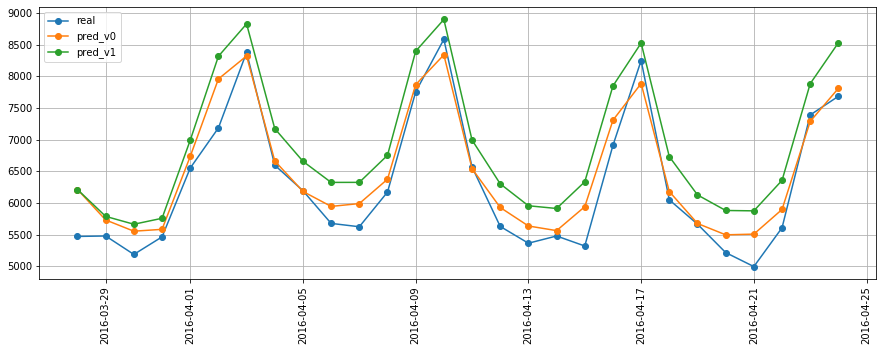

----------------------------------------------------------------------------------------------------
------------------------------------------- store_id: 4 --------------------------------------------
----------------------------------------------------------------------------------------------------
Fitting the model
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.158044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5666
[LightGBM] [Info] Number of data points in the train set: 2256675, number of used features: 64
Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsseL12: 0.877974
[50]	valid_0's wrmsseL12: 0.815895
[75]	valid_0's wrmsseL12: 0.798394
[100]	valid_0's wrmsseL12: 0.793155
[125]	valid_0's wrmsseL12: 0.791263
[150]	valid_0's wrmsseL12: 0.790517
[175]	valid_0's wrmsseL12: 0.789967
[200]	vali

In [ ]:
%%time
folds_errors = list()

for i,valid_period in enumerate(valid_periods):

    print("#"*100)
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    logger.write("#"*100 + "\n")
    logger.write(f" Validation period: {valid_period} ".center(100, "#") + "\n")
    logger.write("#"*100 + "\n\n")

    valid_start = valid_period[0]
    valid_end = valid_period[1]
    scales_level12 = compute_scaling(scaling_input, 
                                     cut_date=valid_start,
                                     agg_columns=["item_id","store_id"]).rename({"q":"s"}, axis=1)
    weights_level12 = compute_weights(weighting_input, 
                                      start_date=valid_start, level=12)
    
    stores_forecast = list()
    
    for store_id in range(1,11):
        print("-"*100)
        print(f" store_id: {store_id} ".center(100, "-"))
        print("-"*100)
    
        _train_data = data.query("ds <= @valid_end & store_id == @store_id").reset_index(drop=True)
        _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index
        
        if store_id in [1,2,3,4]:
            # CA store
            _train_data.drop(["snap_TX", "snap_TX_cum", "snap_WI", "snap_WI_cum"], axis=1, inplace=True)
        elif store_id in [5,6,7]:
            # TX store
            _train_data.drop(["snap_CA", "snap_CA_cum", "snap_WI", "snap_WI_cum"], axis=1, inplace=True)
        else:
            #WI store
            _train_data.drop(["snap_TX", "snap_TX_cum", "snap_CA", "snap_CA_cum"], axis=1, inplace=True)
            
        model_level12 = LightGBMForecaster(**model_kwargs)
        model_level12.prepare_features(train_data=_train_data, valid_index=_valid_index)
        model_level12.train_features.dropna(subset=lagged_features_to_dropna, axis=0, inplace=True)
        model_level12.train_features = reduce_mem_usage(model_level12.train_features)
        model_level12.valid_features = reduce_mem_usage(model_level12.valid_features)
        ts_id_in_train = model_level12.train_features.ts_id.unique()
        model_level12.valid_features = model_level12.valid_features.query("ts_id in @ts_id_in_train")
    
        print("Fitting the model")
        tic = time.time()
        evaluator = WRMSSEEvaluatorL12(model_level12.valid_features, weights_level12, scales_level12)
        model_level12.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})
        tac = time.time()
        print(f"Elapsed time: {(tac-tic)/60.} [min]")

        logger.write(f"- best_iteration: {model_level12.best_iteration} \n\n")
        logger.flush()

        lgb.plot_importance(model_level12.model.model, importance_type="split", figsize=(10,8))
        lgb.plot_importance(model_level12.model.model, importance_type="gain", figsize=(10,8))

        print("Predicting with ground thruth lagged values")
        tic = time.time()
        forecast_v0 = (model_level12.valid_features
                       .loc[:, ["ds"]+model_level12.ts_uid_columns]
                       .assign(y_pred = model_level12.model.predict(model_level12.valid_features)))
        tac = time.time()
        print(f"Elapsed time: {(tac-tic)/60.} [min]")

        wrmsse = evaluator._evaluate(forecast_v0.y_pred.values)
        print("wrmsse:", wrmsse)
    
        logger.write(f"- wrmsse approach 1: {wrmsse} \n\n")
        logger.flush()

        print("Predicting with recursive approach")
        tic = time.time()
        valid_data = model_level12.valid_features.loc[:, model_level12.raw_train_columns].drop("y", axis=1)
        forecast_v1 = model_level12.predict(valid_data, recursive=True)
        tac = time.time()
        print(f"Elapsed time: {(tac-tic)/60.} [min]")
    
        wrmsse = evaluator._evaluate(forecast_v1.y_pred.values)
        print("wrmsse:", wrmsse)
    
        logger.write(f"- wrmsse approach 2: {wrmsse} \n\n")
        logger.flush()
    
        mrg = (model_level12.valid_features.groupby(["ds"])["y"].sum().reset_index()
               .merge(forecast_v0.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds")
               .merge(forecast_v1.groupby(["ds"])["y_pred"].sum().reset_index(), on="ds"))
        plt.figure(figsize=(15,5))
        plt.plot_date(mrg.ds, mrg.y, "o-", label="real")
        plt.plot_date(mrg.ds, mrg.y_pred_x, "o-", label="pred_v0")
        plt.plot_date(mrg.ds, mrg.y_pred_y, "o-", label="pred_v1")
        plt.grid()
        plt.xticks(rotation=90)
        plt.legend(loc="best")
        plt.show()
        
        forecast_v1["store_id"] = store_id
        stores_forecast.append(forecast_v1)
        del model_level12, _train_data, _valid_index, evaluator
        gc.collect()
    
    fold_forecast = pd.concat(stores_forecast, ignore_index=True)
    mrg = pd.merge(data.loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]],
                   fold_forecast, how="inner", on=["ds","item_id","store_id"])
    evaluator = WRMSSEEvaluator(mrg.loc[:, ["ds","item_id","dept_id","cat_id","store_id","state_id","y"]])
    wrmsse = evaluator._evaluate(mrg.y_pred.values)
    print("\nwrmsse:", wrmsse)
    print(evaluator.errors_by_level)
    folds_errors.append(evaluator.errors_by_level)

***

In [11]:
approach1 = list(errors_v0.values())
approach2 = list(errors_v1.values())

logger.write("#"*100 + "\n")
logger.write(f" Overall ".center(100, "#") + "\n")
logger.write("#"*100 + "\n\n")

logger.write(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)} \n\n")
logger.write(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)} \n\n")
logger.flush()

NameError: name 'errors_v0' is not defined

In [ ]:
print(f"- approach 1 on all folds: {approach1} - mean: {np.mean(approach1)}")
print(f"- approach 2 on all folds: {approach2} - mean: {np.mean(approach2)}")

***